# 生成式模型

[生成式模型](https://zhuanlan.zhihu.com/p/659566348)是一类机器学习模型，其主要目的是生成具有与训练数据相似性质的新样本。这些模型通过学习数据的统计规律和潜在结构.能够生成具有类似于训练数据的新数据。生成式模型在多个领域中发挥着重要作用包括图像生成、文本生成、音乐生成等。

其中.[AutoEncoder（自编码器）](https://zhuanlan.zhihu.com/p/80377698)是生成式模型的一种常见类型。它由两部分组成：编码器和解码器。编码器将输入数据映射到一个低维表示.称为编码。解码器则将编码映射回原始数据空间.以重构输入数据。AutoEncoder的目标是使重构数据尽可能接近原始数据.从而学习到数据的潜在表示和特征。通过调整编码的维度.AutoEncoder可以用于数据降维、特征提取、去噪等任务。

另一种生成式模型是[变分自编码器（Variational AutoEncoder.VAE）](https://zhuanlan.zhihu.com/p/348498294)。VAE是基于AutoEncoder的扩展.引入了概率编码的概念。VAE假设输入数据的生成过程是由潜在变量和条件分布共同决定的.它通过编码器将输入数据映射到潜在空间.并利用编码的概率分布来生成随机样本。VAE通过最大化数据的边际对数似然来训练模型.并通过重参数化技巧来近似梯度的计算。VAE具有较好的采样性能.可以生成具有多样性的新样本。

[扩散模型（Diffusion Model）](https://zhuanlan.zhihu.com/p/525106459)是一种生成式模型.其目标是通过迭代地对当前样本添加噪声来生成新样本。扩散模型利用随机梯度下降的方法.通过最小化输入数据与当前样本之间的差异来学习生成新样本的过程。扩散模型在图像生成、图像修复以及图像编辑等任务中具有重要应用。

生成式模型为数据生成、数据增强、异常检测等任务提供了强大的工具和技术支持.是未来AIGC时代的基石。本次**作业**将包括以下内容：

1. 实现一个简单的AutoEncoder生成中文手写数字
2. 实现一个简单的VAE可控地生成中文手写数字
3. 理解扩散模型的本质.并填写相应代码

**你只需要在出现"TODO"字样的地方进行编码.生成式模型的数学公式可能有些复杂.但是模型的实现代码都很简单。请不要修改在TODO处助教定义的函数名或者变量名.这些名称将用于自动化评测实现的正确性。**

![一些生成式模型](https://ai-studio-static-online.cdn.bcebos.com/d05ce24b5f6c43e6abfa928068074e5c6f8b0400d5f142c8a62ff1a953dab1a0)

## 编码环境以及辅助代码

利用BML CodeLab的环境配置功能.我们已经为同学们配置了基础环境。该环境可以大概表述为：

1. Linux
2. Python3.10.10（附带pip）
3. 百度paddlepaddle 2.6.0
4. matplotlib 3.8.2
5. numpy 1.26.2
6. opencv-python 4.8.1.78
7. 中文手写数字数据集
8. ......(一些其他的包)

若同学们有其他需要.请自行参考BML CodeLab的文档安装其他Python包。下面这个命令可以查看当前环境的所有Python包：

In [1]:
# 查看当前环境的所有Python包
!pip list
!pip install scikit-learn

Package                    Version
-------------------------- -----------
aiofiles                   23.2.1
aiohappyeyeballs           2.4.4
aiohttp                    3.11.11
aiosignal                  1.3.2
aistudio-sdk               0.2.6
altair                     4.2.2
annotated-types            0.7.0
anyio                      4.7.0
astor                      0.8.1
asttokens                  3.0.0
async-timeout              5.0.1
attrs                      24.3.0
babel                      2.16.0
bce-python-sdk             0.9.25
blinker                    1.9.0
cachetools                 5.5.2
certifi                    2024.12.14
charset-normalizer         3.4.1
click                      8.1.8
colorama                   0.4.6
colorlog                   6.9.0
comm                       0.2.2
contourpy                  1.3.1
cycler                     0.12.1
datasets                   3.2.0
debugpy                    1.8.11
decorator                  5.1.1
dill                  

### 辅助代码

这一部分代码主要负责导入Python包, 显示图像等功能.和模型无关.在此单独列出：

In [1]:
# import python package
import os

import copy
import cv2
import numpy as np
import paddle
import paddle.nn as nn 
import paddle.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from paddle.io import Dataset, DataLoader
from paddle.optimizer import Adam

In [2]:
# utility
def show_images(*images):
    num_images = len(images)
    rows = (num_images + 5) // 6  # 计算需要的行数

    fig, axes = plt.subplots(rows, 6, figsize=(12, 2 * rows))
    axes = axes.flatten()

    for i, image in enumerate(images):
        axes[i].imshow(image)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

### 数据集准备

运行下面的代码块即可将数据集解压到我们指定的位置（如无必要.请不要更改数据集存放的位置）.并开始作业的编码：

data106824
标签： 0
图像数据Shape: (64, 64, 3)
OneHot标签: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


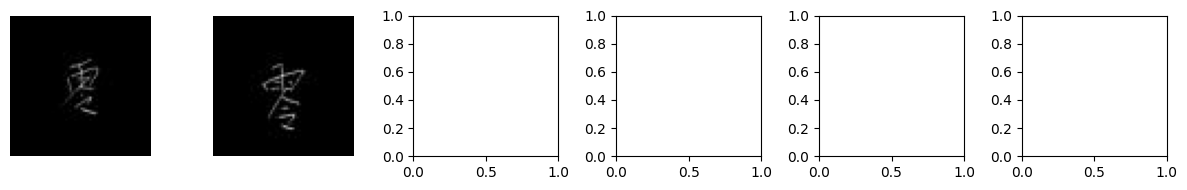

In [3]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. 
# This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. 
# All changes under this directory will be kept even after reset. 
# Please clean unnecessary files in time to speed up environment loading. 
!ls /home/aistudio/work

# 硬编码的常量定义
DATA_FOLDER = '/home/aistudio/data/data/data'
DATA_LABEL = 'home/aistudio/data/chinese_mnist.csv'
MAX_DIGIT = 15 # 标签从0到14.依次是零.一.二.三.....十.百.千.万.亿.共15个中文数字

# 解压数据集到指定目录.并定义数据路径和数据集类
if not os.path.exists(DATA_FOLDER):
    !unzip -qo /home/aistudio/data/data106824/*.zip -d /home/aistudio/data

class CNDigit(Dataset):
    def __init__(self):
        self.data = []

        for root, dirs, files in os.walk(DATA_FOLDER):
            for _file in files:
                file_path = os.path.join(root, _file)
                image = np.array(cv2.imread(file_path))
                label = int(_file.split('_')[-1].split('.')[0]) - 1
                one_hot_label = np.zeros(MAX_DIGIT)
                one_hot_label[label] = 1
                self.data.append((label, image, one_hot_label))
        
        self.data = sorted(self.data, key=lambda x: x[0])

    def __getitem__(self,idx):
        return self.data[idx]

    def __len__(self):
        return len(self.data)

# 构建并测试数据集
dataset = CNDigit()

print('标签：', dataset[0][0])
print('图像数据Shape:', dataset[0][1].shape)
print('OneHot标签:', dataset[0][2])

show_images(dataset[0][1],dataset[1][1])

## 任务一 AE生成手写数字

[AutoEncoder（自编码器）](https://baike.baidu.com/item/%E8%87%AA%E7%BC%96%E7%A0%81%E5%99%A8/23686966)是一种无监督学习的生成式模型.由编码器和解码器组成。它通过学习数据的潜在表示和特征.可以用于数据降维、特征提取、去噪等任务。AutoEncoder的目标是将输入数据经过编码器映射到一个低维表示.然后通过解码器将该低维表示映射回原始数据空间.以重构原始数据。

具体而言.AutoEncoder的编码器部分将输入数据进行编码.将高维输入数据转换为低维的编码表示。编码器通常由多层神经网络组成.每一层都通过非线性激活函数对输入数据进行变换和抽象。编码器的最后一层输出的编码向量是数据的低维表示。

解码器部分接收编码器输出的编码向量.并将其映射回原始数据空间。解码器也由多层神经网络组成.其结构与编码器相似.但是层数和神经元的数量可能不同。最终.解码器的输出应该与原始输入数据尽可能接近.以实现数据重构的目标。

AutoEncoder的训练过程是无监督的.它通过最小化输入数据与重构数据之间的差异来学习模型参数。常用的损失函数是均方差（Mean Squared Error）.它衡量了输入数据与重构数据之间的平均差异。通过反向传播算法和梯度下降优化器.可以更新编码器和解码器的参数.使得重构数据尽可能接近原始数据。

AutoEncoder的一个重要应用是数据降维。通过训练一个具有较低维度编码的AutoEncoder.可以实现对高维数据的降维表示.去除数据中的冗余信息.提取主要特征。这有助于可视化数据、减少存储空间和计算成本.并在某些情况下提高模型的泛化能力。


**请不要修改在TODO处助教定义的函数名或者变量名.这些名称将用于自动化评测实现的正确性.在这一部分作业中有1个TODO:**

**1. 将自编码器(AE)的网络结构补充完整**

### 自编码器(AE)网络结构

In [202]:
class AutoEncoder(nn.Layer):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        '''
        TODO: 请使用paddle将自编码器的编码器self.encoder和解码器self.decoder补充完整。

        self.encoder的网络结构按顺序是:
        1. 2D卷积层, input_channel = 3, output_channel = 16, kernel_size = 3, stride = 1, padding = 1
        2. Relu层
        3. BatchNorm
        4. MaxPool, kernel_size = 2, stride = 2
        5. 2D卷积层, output_channel = 32, kernel_size = 3, stride = 1, padding = 1
        6. Relu层
        7. BatchNorm
        8. MaxPool, kernel_size = 2, stride = 2

        self.decoder的网络结构按顺序是:
        1. 转置2D卷积层, output_channel = 16, kernel_size = 2, stride = 2
        2. Relu
        3. BatchNorm
        4. 转置2D卷积层, output_channel = 3, kernel_size = 2, stride = 2
        5. Sigmoid

        在实现的过程中.请思考:64*64*3的图像在通过各个网络层时维度会改变成多少?
        '''
        self.encoder = nn.Sequential(
            # Input: [B, 3, 64, 64]
            nn.Conv2D(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),  # -> [B, 16, 64, 64]
            nn.ReLU(),
            nn.BatchNorm2D(16),
            nn.MaxPool2D(kernel_size=2, stride=2),                                       # -> [B, 16, 32, 32]
            nn.Conv2D(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),# -> [B, 32, 32, 32]
            nn.ReLU(),
            nn.BatchNorm2D(32),
            nn.MaxPool2D(kernel_size=2, stride=2)                                        # -> [B, 32, 16, 16]
        )
        self.decoder = nn.Sequential(
            # Input: [B, 32, 16, 16]
            nn.Conv2DTranspose(in_channels=32, out_channels=16, kernel_size=2, stride=2), # -> [B, 16, 32, 32]
            nn.ReLU(),
            nn.BatchNorm2D(16),
            nn.Conv2DTranspose(in_channels=16, out_channels=3, kernel_size=2, stride=2),  # -> [B, 3, 64, 64]
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

### 自编码器的训练

In [203]:
# 超参数
num_epochs = 100
batch_size = 256
learning_rate = 0.005

white_threshold = 0.5
white_region_loss_coef = 1
black_region_loss_coef = 0.1

# 实例化AutoEncoder
autoencoder = AutoEncoder()

# 定义优化器和损失函数
optimizer = Adam(learning_rate=learning_rate, parameters=autoencoder.parameters())
loss_fn = nn.MSELoss()

# 定义DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 训练循环
for epoch in range(num_epochs):
    for batch_id, batch_data in enumerate(dataloader):
        # input
        input_labels, input_data, input_one_hot = batch_data
        input_data = input_data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.0

        # 前向传播
        output_data = autoencoder(input_data)
        
        # 计算损失
        # 由于数据集中的图像黑色部分很多.所以这里我们突出白色部分的权重.防止生成一张全黑的图像
        white_region = paddle.where(input_data > white_threshold)
        loss = white_region_loss_coef * loss_fn(output_data[white_region], input_data[white_region])

        black_region = paddle.where(input_data < white_threshold)
        loss += black_region_loss_coef * loss_fn(output_data[black_region], input_data[black_region])
        
        # 反向传播和优化
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()
        
        print(f"Epoch {epoch}, batch_id {batch_id}, Loss: {loss.numpy()}")

# 保存训练结果
paddle.save(autoencoder.state_dict(), 'autoencoder.pdparams')
print("Model saved.")

Epoch 83, batch_id 5, Loss: 0.0013058856129646301
Epoch 83, batch_id 6, Loss: 0.0012088366784155369
Epoch 83, batch_id 7, Loss: 0.0013792647514492273
Epoch 83, batch_id 8, Loss: 0.0012452073860913515
Epoch 83, batch_id 9, Loss: 0.001993895508348942
Epoch 83, batch_id 10, Loss: 0.001561388955451548
Epoch 83, batch_id 11, Loss: 0.0013224415015429258
Epoch 83, batch_id 12, Loss: 0.0012538803275674582
Epoch 83, batch_id 13, Loss: 0.0015404425794258714
Epoch 83, batch_id 14, Loss: 0.0015079176519066095
Epoch 83, batch_id 15, Loss: 0.0017765823286026716
Epoch 83, batch_id 16, Loss: 0.0016744621098041534
Epoch 83, batch_id 17, Loss: 0.0018754899501800537
Epoch 83, batch_id 18, Loss: 0.0014349789125844836
Epoch 83, batch_id 19, Loss: 0.001388979610055685
Epoch 83, batch_id 20, Loss: 0.0013743912568315864
Epoch 83, batch_id 21, Loss: 0.0014116194797679782
Epoch 83, batch_id 22, Loss: 0.0015642514917999506
Epoch 83, batch_id 23, Loss: 0.0014276134315878153
Epoch 83, batch_id 24, Loss: 0.00127891

### 自编码器的推理

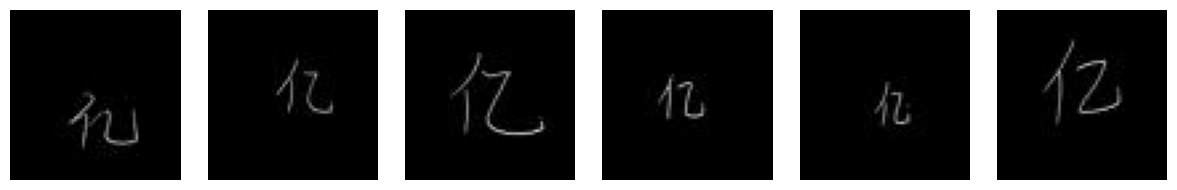

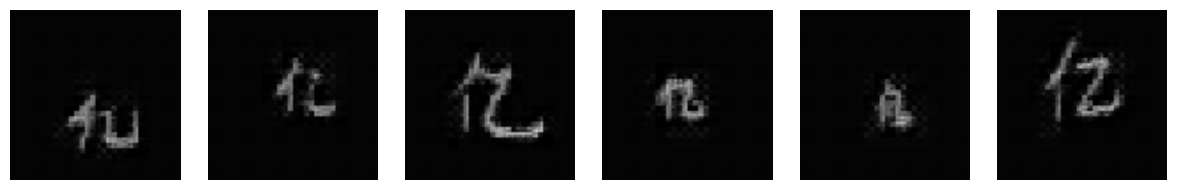

In [205]:
# 创建模型实例
autoencoder = AutoEncoder()

# 加载模型参数
model_path = 'autoencoder.pdparams'
state_dict = paddle.load(model_path)

# 将参数加载到模型中
autoencoder.set_state_dict(state_dict)

# 尝试重建数字“亿”
# 构建输入数据
input_images = np.concatenate([item[1][np.newaxis, :] for item in dataset[14000:14006]])
input_data = np.concatenate([item[1][np.newaxis, :] for item in dataset[14000:14006]])
input_data = input_data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.0
input_data = paddle.to_tensor(input_data)

# 中间的隐变量
embedding = autoencoder.encoder(input_data)

# 将隐变量输入decoder
output_data = autoencoder.decoder(embedding)
output_data = paddle.clip(output_data * 255, 0, 255) # 将数据映射到0-255的像素值范围
output_data = paddle.cast(output_data, 'uint8').transpose((0, 2, 3, 1)) # 将张量转换为uint8类型

# 将输入图像和重建的图像展示出来
show_images(*input_images)
show_images(*output_data)

## 任务二 VAE生成手写数字

[变分自编码器（VAE）](https://zhuanlan.zhihu.com/p/64485020)是一种生成式模型.它是自编码器（AutoEncoder）的扩展。与传统的自编码器不同.VAE引入了概率编码的概念.允许对数据的潜在表示进行建模并生成具有多样性的新样本。

VAE的核心思想是假设输入数据的生成过程是由潜在变量和条件分布共同决定的。它通过编码器将输入数据映射到潜在空间.并利用潜在变量的概率分布来生成随机样本。VAE的潜在空间通常是一个均值和方差来参数化的高斯分布。

具体而言.VAE的编码器部分将输入数据映射到潜在空间.并学习生成潜在变量的均值和方差。编码器通常由多层神经网络组成.其中最后一层输出的均值和方差用于参数化潜在变量的分布。通过这种方式.VAE可以学习到数据在潜在空间的分布和结构。

解码器部分接收从潜在空间采样得到的潜在变量.并将其解码为原始数据空间中的样本。解码器也由多层神经网络组成.其结构与编码器相似。通过最大化重构数据的对数似然.VAE的目标是使解码器生成的样本尽可能接近原始输入数据。

VAE的训练过程涉及两个损失函数：重构损失和KL散度损失。重构损失衡量了输入数据与重构数据之间的差异.类似于传统自编码器的训练目标。KL散度损失则用于衡量编码器输出的潜在变量分布与预设的潜在变量分布之间的差异。通过最小化这两个损失函数.VAE可以学习到数据的潜在表示和特征。

VAE的一个重要特性是其采样性能。通过在潜在空间中采样不同的潜在变量.并通过解码器生成样本.VAE可以生成具有多样性的新样本。这使得VAE在生成新数据、样本插值和探索潜在空间等任务中具有优势。

**请不要修改在TODO处助教定义的函数名或者变量名.这些名称将用于自动化评测实现的正确性.在这一部分作业中有3个TODO:**

**1. 将变分自编码器重参数化部分的代码补充完整** 

**2. 将变分自编码器中的KL散度损失代码补充完整**

**3. 调整损失函数、网络结构或者参数使得生成结果更清晰**

### 变分自编码器(VAE)网络结构

In [4]:
class CVAE(nn.Layer):
    def __init__(self, img_channels, img_size, latent_dim, num_classes):
        super(CVAE, self).__init__()
        self.img_channels = img_channels
        self.img_size = img_size
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        self.encoder = nn.Sequential(
            nn.Conv2D(img_channels + num_classes, 32, 4, stride=2, padding=1),
            nn.BatchNorm2D(32),
            nn.Tanh(),
            nn.Conv2D(32, 64, 4, stride=2, padding=1),
            nn.BatchNorm2D(64), 
            nn.Tanh(),
            nn.Conv2D(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2D(128),
            nn.Tanh(),
            nn.Flatten(),
            nn.Linear(128 * (img_size // 8) * (img_size // 8), 1024),
            nn.Tanh(),
            nn.Linear(1024, 512), 
            nn.Tanh()
        )

        self.fc_mu = nn.Linear(512, latent_dim)
        self.fc_logvar = nn.Linear(512, latent_dim)

        self.decoder_input = nn.Linear(latent_dim + num_classes, 512)

        self.decoder = nn.Sequential(
            nn.Linear(512, 1024), 
            nn.Tanh(),
            nn.Linear(1024, 128 * (img_size // 8) * (img_size // 8)),
            nn.Tanh(),
            nn.Unflatten(1, [128, img_size // 8, img_size // 8]),
            nn.Conv2DTranspose(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2D(64),
            nn.Tanh(),
            nn.Conv2DTranspose(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2D(32),
            nn.Tanh(),
            nn.Conv2DTranspose(32, img_channels, 4, stride=2, padding=1),
            nn.Sigmoid()
        )

    '''
    TODO: 请使用paddle实现重参数化函数self.reparameterize(self, mu, logvar, eps = None)
        该函数的功能是从均值是mu,方差是var的高斯分布中采样出一个样本,并将该样本返回。
        注意:这里的logvar是方差的对数,而非方差,要进行转化。
        如果给定了eps,那么就将eps作为重参数化的参数,否则从标准高斯分布中采样出一个eps作为重参数化的参数。
    
    在实现的过程中.请思考：为什么变分自编码器需要重参数化？
    '''   
    def reparameterize(self, mu, logvar, eps = None):
        # 变分重参数化：采样 z = mu + std * eps
        var = paddle.exp(logvar)
        std = paddle.sqrt(var + 1e-8)
        if eps is None:
            eps = paddle.randn(mu.shape)
        return mu + eps * std

    def sample(self, labels):
        one_hot = F.one_hot(labels, self.num_classes)
        z = paddle.randn([len(labels), self.latent_dim])
        z = paddle.concat([z, one_hot], axis = 1)
        decoded_input = self.decoder_input(z)
        reconstruction = self.decoder(decoded_input)
        return reconstruction
    
    def forward(self, x, labels):
        # 将标签信息扩展为与图像大小相同并与输入图像连接
        labels = labels.unsqueeze(2).unsqueeze(3)
        labels = labels.expand([-1, -1, self.img_size, self.img_size])
        x = paddle.concat([x, labels], axis=1)
        
        # 编码过程
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        
        # 将潜在向量与标签连接作为解码器的输入
        z = paddle.concat([z, labels[:, :, 0, 0]], axis=1)
        z_copy = copy.deepcopy(z) # z_copy是后续可视化操作时要使用的
        decoded_input = self.decoder_input(z)
        reconstruction = self.decoder(decoded_input)
        return reconstruction, mu, logvar, z_copy

# import paddle
# import paddle.nn as nn
# import paddle.nn.functional as F
# import numpy as np


# class CVAE(nn.Layer):
#     def __init__(self, img_channels, img_size, latent_dim, num_classes):
#         super(CVAE, self).__init__()
#         self.img_channels = img_channels  # 输入图像通道数
#         self.img_size = img_size          # 输入图像尺寸（假设是正方形）
#         self.latent_dim = latent_dim      # 潜在空间维度
#         self.num_classes = num_classes    # 条件类别数

#         # 编码器网络（含条件信息）
#         self.encoder = nn.Sequential(
#             # 输入：(img_channels + num_classes) x img_size x img_size
#             nn.Conv2D(img_channels + num_classes, 32, 4, stride=2, padding=1),
#             nn.BatchNorm2D(32),
#             nn.Tanh(),

#             nn.Conv2D(32, 64, 4, stride=2, padding=1),
#             nn.BatchNorm2D(64),
#             nn.Tanh(),

#             nn.Conv2D(64, 128, 4, stride=2, padding=1),
#             nn.BatchNorm2D(128),
#             nn.Tanh(),

#             nn.Flatten(),  # 展平为一维向量
            
#             # 全连接降维
#             nn.Linear(128 * (img_size // 8) * (img_size // 8), 1024),
#             nn.Tanh(),
            
#             nn.Linear(1024, 512),
#             nn.Tanh()
#         )

#         # 潜在空间参数层
#         self.fc_mu = nn.Linear(512, latent_dim)         # 均值输出层
#         self.fc_logvar = nn.Linear(512, latent_dim)     # 对数方差输出层

#         # 解码器输入映射（含条件信息）
#         self.decoder_input = nn.Linear(latent_dim + num_classes, 512)

#         # 解码器网络
#         self.decoder = nn.Sequential(
#             nn.Linear(512, 1024),
#             nn.Tanh(),

#             nn.Linear(1024, 128 * (img_size // 8) * (img_size // 8)),
#             nn.Tanh(),

#             # 恢复为三维特征图：[128, img_size//8, img_size//8]
#             nn.Unflatten(1, (128, img_size // 8, img_size // 8)),

#             # 转置卷积上采样
#             nn.Conv2DTranspose(128, 64, 4, stride=2, padding=1),
#             nn.BatchNorm2D(64),
#             nn.Tanh(),

#             nn.Conv2DTranspose(64, 32, 4, stride=2, padding=1),
#             nn.BatchNorm2D(32),
#             nn.Tanh(),

#             # 输出与输入图像同尺寸的特征图
#             nn.Conv2DTranspose(32, img_channels, 4, stride=2, padding=1),
#             nn.Sigmoid()  # 像素值归一化到 [0,1]
#         )

#     def reparameterize(self, mu, logvar, eps=None):
#         """
#         重参数化技巧：从潜在分布中采样
#         参数：
#             mu (Tensor): 潜在分布均值
#             logvar (Tensor): 潜在分布对数方差（log(σ²)）
#             eps (Tensor, optional): 预定义的采样噪声，默认从标准正态分布生成
#         返回：
#             Tensor: 采样得到的潜在变量 z
#         """
#         # 计算标准差 σ = exp(0.5 * logvar)
#         std = paddle.exp(0.5 * logvar)
        
#         # 生成或使用预定义噪声
#         if eps is None:
#             eps = paddle.randn(mu.shape)  # 标准正态分布采样
            
#         # 重参数化公式：z = μ + ε * σ
#         return mu + eps * std

#     def sample(self, labels):
#         """
#         从先验分布采样生成图像（条件生成）
#         参数：
#             labels (Tensor): 条件标签（整数形式）
#         返回：
#             Tensor: 生成的图像
#         """
#         # 将标签转换为 one-hot 编码（形状：[batch_size, num_classes]）
#         one_hot = F.one_hot(labels, self.num_classes)
        
#         # 从标准正态分布采样潜在变量（形状：[batch_size, latent_dim]）
#         z = paddle.randn([len(labels), self.latent_dim])
        
#         # 合并潜在变量与条件信息
#         z_cond = paddle.concat([z, one_hot], axis=1)
        
#         # 解码生成图像
#         decoded_input = self.decoder_input(z_cond)
#         reconstruction = self.decoder(decoded_input)
#         return reconstruction

#     def forward(self, x, labels):
#         """
#         前向传播
#         参数：
#             x (Tensor): 输入图像（形状：[batch_size, img_channels, img_size, img_size]）
#             labels (Tensor): 条件标签（整数形式，形状：[batch_size]）
#         返回：
#             Tensor: 重构图像
#             Tensor: 潜在分布均值 mu
#             Tensor: 潜在分布对数方差 logvar
#             Tensor: 采样的潜在变量 z（用于可视化）
#         """
#         # 1. 条件信息与输入图像融合
#         # 将标签转换为 one-hot 并扩展为与图像同尺寸的特征图
#         # 原标签形状：[batch_size] → 扩展后形状：[batch_size, num_classes, img_size, img_size]
#         one_hot = F.one_hot(labels, self.num_classes)  # [batch_size, num_classes]
#         one_hot = one_hot.unsqueeze(2).unsqueeze(3)    # [batch_size, num_classes, 1, 1]
#         one_hot = one_hot.expand([-1, -1, self.img_size, self.img_size])  # 扩展为图像尺寸
        
#         # 拼接输入图像与条件信息（通道维度）
#         x_cond = paddle.concat([x, one_hot], axis=1)  # 形状：[batch_size, img_channels+num_classes, H, W]

#         # 2. 编码过程
#         encoded = self.encoder(x_cond)  # 编码器输出特征（形状：[batch_size, 512]）
#         mu = self.fc_mu(encoded)        # 潜在均值（形状：[batch_size, latent_dim]）
#         logvar = self.fc_logvar(encoded)# 潜在对数方差（形状：[batch_size, latent_dim]）
#         z = self.reparameterize(mu, logvar)  # 采样潜在变量（形状：[batch_size, latent_dim]）

#         # 3. 解码过程（合并潜在变量与条件信息）
#         # 条件信息取特征图的左上角元素（已包含全局类别信息）
#         cond_info = one_hot[:, :, 0, 0]  # 形状：[batch_size, num_classes]
#         z_cond = paddle.concat([z, cond_info], axis=1)  # 合并潜在变量与条件信息
        
#         # 注意：这里使用 z_copy 保存用于可视化的潜在变量（避免后续操作修改原张量）
#         z_copy = paddle.clone(z_cond)
        
#         # 解码生成图像
#         decoded_input = self.decoder_input(z_cond)
#         reconstruction = self.decoder(decoded_input)  # 重构图像（形状：[batch_size, img_channels, H, W]）

#         return reconstruction, mu, logvar, z_copy
    

### 变分自编码器的训练

In [95]:
'''
TODO: 
尝试修改VAE的损失函数相关部分,使其生成的效果更好、更清晰。
也可以尝试修改上面VAE的网络结构。
具体做法可以参考实验指导书 ~
将最终生成的结果截图放入实验报告中
'''

# # 超参数
# beta = 1.0 # 这个值是否合适？尝试修改这个权重

# # 训练参数
# num_epochs = 300
# batch_size = 256
# learning_rate = 1e-3

# # 下面三个值需要根据实际情况进行调整
# white_threshold = 0.5
# white_region_loss_coef = 1
# black_region_loss_coef = 0.3

# 超参数调整：减小beta，加大学习率
beta = 1.0
# learning_rate = 0.0003
learning_rate = 0.0003

# 训练参数
num_epochs = 150
batch_size = 64
# batch_data = 128
# batch_size = 256

white_threshold = 0.7
white_region_loss_coef = 1.0
black_region_loss_coef = 0.3

# 模型实例化
cvae = CVAE(3, 64, 32, MAX_DIGIT)
# cvae = CVAE(3, 64, 64, MAX_DIGIT)


# 选择优化器
optimizer = Adam(parameters=cvae.parameters(), learning_rate=learning_rate, beta1=0.8, beta2=0.99)

# 定义DataLoader
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# KL损失函数
'''
TODO: 请使用paddle实现VAE中的KL散度损失kl_div_loss(mu, logvar)
    该函数的功能是,求出以mu为均值和var为方差的高斯分布和标准高斯分布之间的KL散度损失
    具体的公式可以参考前文给出的知乎链接(Notebook中的蓝色字体是链接),logvar = log(var)

在实现的过程中,请思考:引入这个KL散度损失有什么好处?又有什么坏处?
'''
def kl_div_loss(mu, logvar):
    # KL(N(mu,var) || N(0,1)) = -0.5 * sum(1 + logvar - mu^2 - var)
    var = paddle.exp(logvar)
    kl = -0.5 * paddle.sum(1 + logvar - mu**2 - var, axis=1)
    return paddle.mean(kl)

# 训练循环
for epoch in range(num_epochs):
    for batch_idx, (labels, x, one_hot) in enumerate(data_loader):
        # 确保标签是独热编码.且图像的维度顺序正确
        labels = one_hot.astype(paddle.float32)
        x = x.transpose((0, 3, 1, 2)).astype(np.float32) / 255.0

        # 前向传播
        reconstruction, mu, logvar, _ = cvae(x, labels)

        # 重构损失
        # 由于数据集中的图像黑色部分很多.所以这里我们突出白色部分的权重.防止生成一张全黑的图像
        # white_region = paddle.where(x > white_threshold)
        # white_recon_loss = F.mse_loss(reconstruction[white_region], x[white_region], reduction='mean')

        # black_region = paddle.where(x < white_threshold)
        # black_recon_loss = F.mse_loss(reconstruction[black_region], x[black_region], reduction='mean')

        # recon_loss = white_region_loss_coef * white_recon_loss + black_region_loss_coef * black_recon_loss

        white_region = paddle.where(x > white_threshold)
        white_recon_loss = F.smooth_l1_loss(reconstruction[white_region], x[white_region], reduction='sum')

        black_region = paddle.where(x < white_threshold)
        black_recon_loss = F.smooth_l1_loss(reconstruction[black_region], x[black_region], reduction='sum')

        recon_loss = white_region_loss_coef * white_recon_loss + black_region_loss_coef * black_recon_loss

        # KL散度
        kl_div = kl_div_loss(mu, logvar)

        # 总损失
        loss = recon_loss + beta * kl_div

        # 反向传播
        loss.backward()
        optimizer.step()
        optimizer.clear_grad()

        if batch_idx % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(data_loader)}], Loss: {loss.item()}')

# 保存训练结果
paddle.save(cvae.state_dict(), 'cvae.pdparams')
print("Model saved.")

Epoch [67/150], Step [200/235], Loss: 231.41159057617188
Epoch [67/150], Step [220/235], Loss: 238.08706665039062
Epoch [68/150], Step [0/235], Loss: 195.9581756591797
Epoch [68/150], Step [20/235], Loss: 213.00233459472656
Epoch [68/150], Step [40/235], Loss: 188.85040283203125
Epoch [68/150], Step [60/235], Loss: 203.81494140625
Epoch [68/150], Step [80/235], Loss: 222.97067260742188
Epoch [68/150], Step [100/235], Loss: 209.6329345703125
Epoch [68/150], Step [120/235], Loss: 230.2567138671875
Epoch [68/150], Step [140/235], Loss: 224.99887084960938
Epoch [68/150], Step [160/235], Loss: 197.52085876464844
Epoch [68/150], Step [180/235], Loss: 228.26539611816406
Epoch [68/150], Step [200/235], Loss: 206.98390197753906
Epoch [68/150], Step [220/235], Loss: 241.55955505371094
Epoch [69/150], Step [0/235], Loss: 239.28030395507812
Epoch [69/150], Step [20/235], Loss: 224.71231079101562
Epoch [69/150], Step [40/235], Loss: 238.81484985351562
Epoch [69/150], Step [60/235], Loss: 205.463745

### 变分自编码器的推理

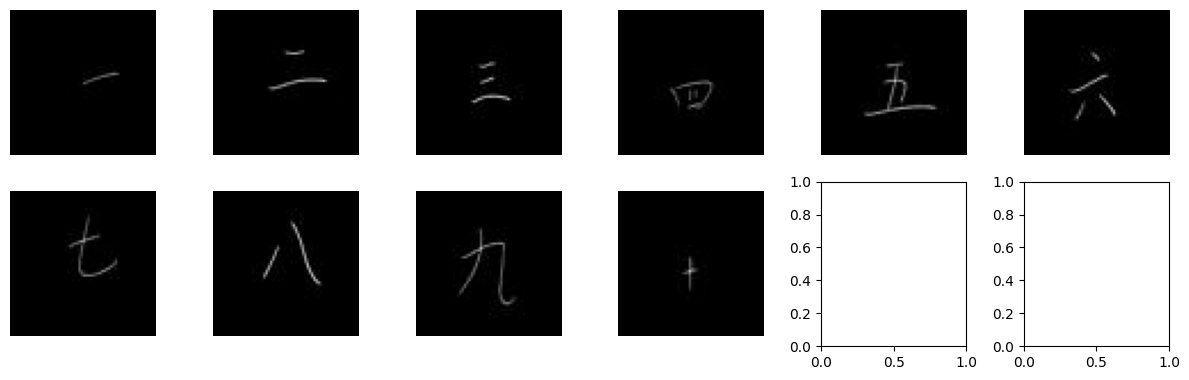

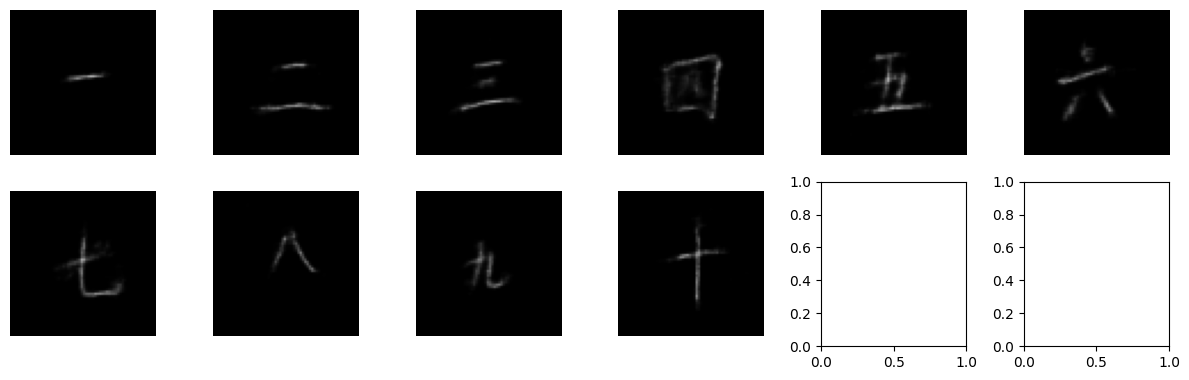

In [200]:
# 创建模型实例
cvae = CVAE(3, 64, 32, MAX_DIGIT)

# 加载模型参数
model_path = 'cvae.pdparams'
state_dict = paddle.load(model_path)

# 将参数加载到模型中
cvae.set_state_dict(state_dict)

# 数据集中的图像
input_images = np.concatenate([item[1][np.newaxis, :] for item in dataset[1000:10001:1000]])
# 生成的图像
output_data = cvae.sample(paddle.to_tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10]))
output_data = paddle.clip(output_data * 255, 0, 255) # 将数据映射到0-255的像素值范围
output_data = paddle.cast(output_data, 'uint8').transpose((0, 2, 3, 1)) # 将张量转换为uint8类型

# 将数据集中的图像和生成的的图像展示出来
show_images(*input_images)
show_images(*output_data)

### 隐变量可视化
无论是ae还是vae都会把输入的图片通过编码器嵌入到隐空间中，通过学习我们知道vae对隐变量的分布具有一定的约束，那么我们希望通过可视化来直观感受二者的区别。  
这里用到了[t-sne](https://zhuanlan.zhihu.com/p/148170862)可视化和降维算法,在训练好ae和vae后(请确保生成效果较为清晰),运行这段可视化代码比较二者的区别,结合理论知识解释并写入**实验报告**中。  
如果你觉得可视化结果不符合你的预期,可以自行调整参数。

应用PCA降至8维...
应用t-SNE降至2维...


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


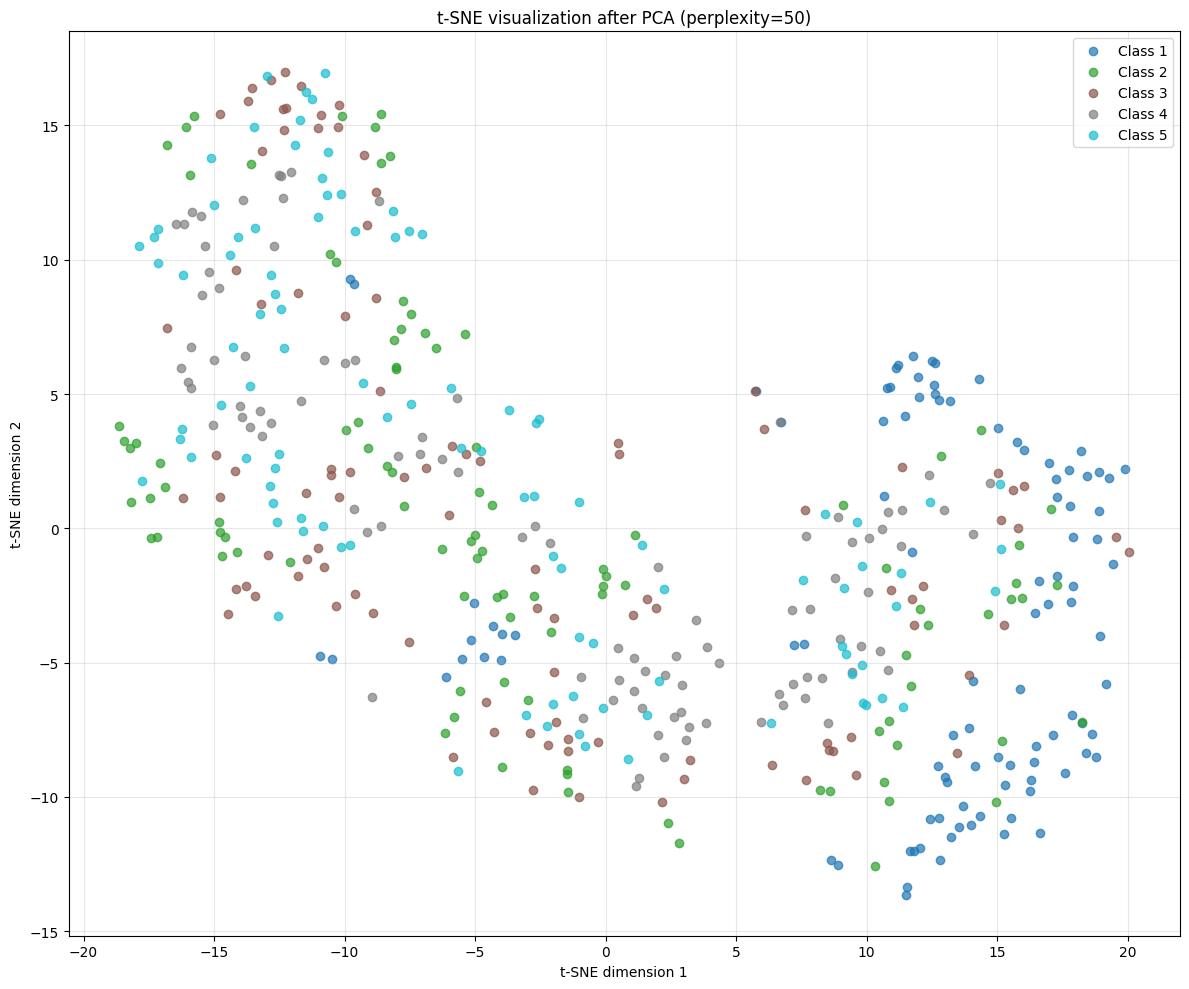

应用PCA降至8维...
应用t-SNE降至2维...


/opt/conda/envs/python35-paddle120-env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


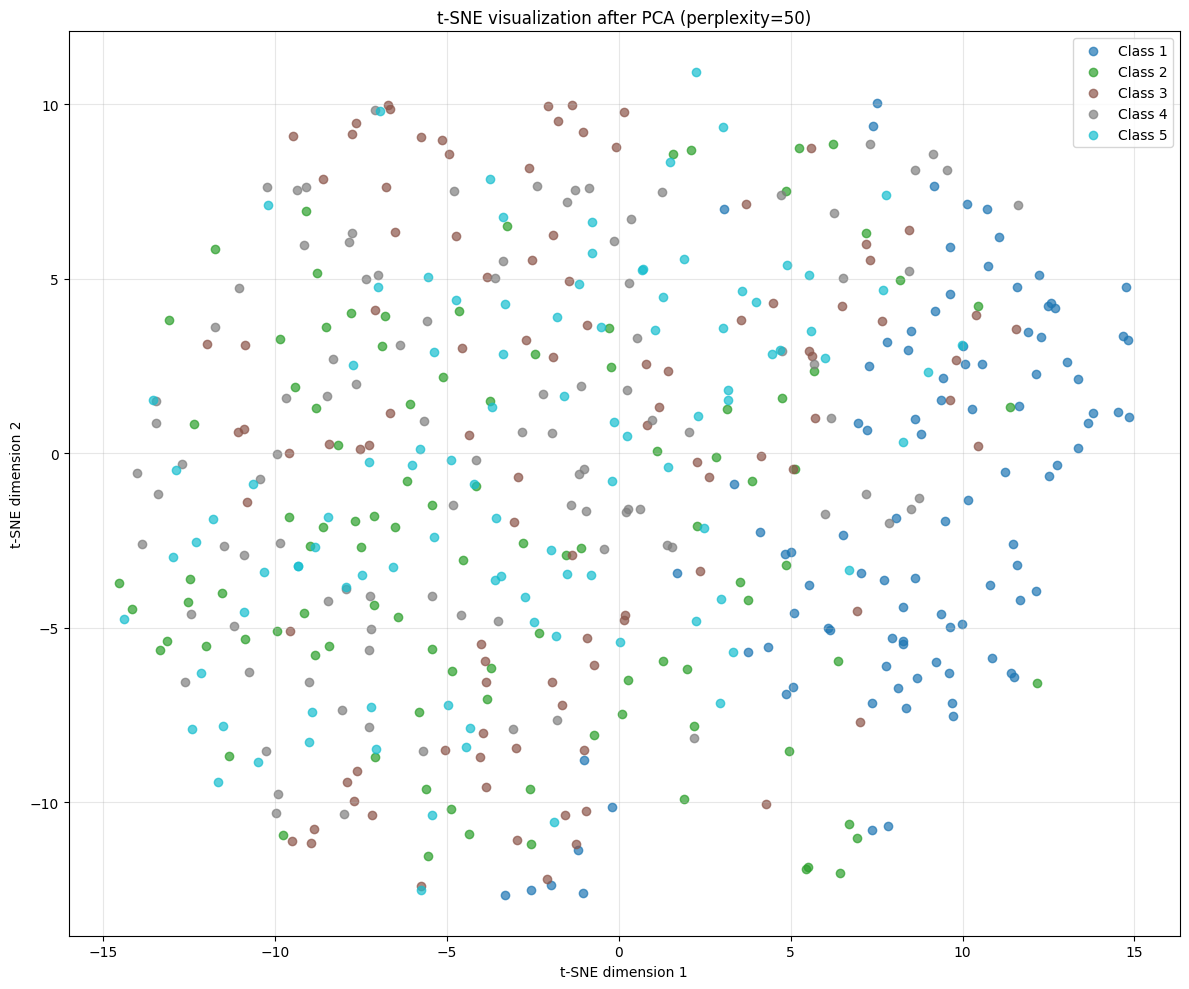

array([[ 1.48285837e+01,  3.23368478e+00],
       [ 1.00803089e+01,  2.57249165e+00],
       [ 3.75898051e+00, -5.68668985e+00],
       [ 8.36953354e+00, -7.29828644e+00],
       [ 1.48573103e+01,  1.02767599e+00],
       [ 9.43341541e+00,  2.15480661e+00],
       [ 1.07348585e+01,  5.37124920e+00],
       [ 1.21437473e+01,  2.27064466e+00],
       [ 9.61388111e+00, -6.30224276e+00],
       [ 7.23409986e+00,  6.79270804e-01],
       [ 7.51723814e+00,  1.00356665e+01],
       [ 9.62111855e+00, -4.96797228e+00],
       [ 1.16545105e+01,  1.34467399e+00],
       [ 7.71626329e+00, -3.63352942e+00],
       [ 1.37972851e+01,  1.16076541e+00],
       [ 7.05076790e+00, -3.44247365e+00],
       [ 9.22470284e+00, -5.97742462e+00],
       [ 1.16852465e+01, -4.19577646e+00],
       [ 9.20021915e+00,  4.06812620e+00],
       [-1.00144172e+00, -8.79910469e+00],
       [ 7.28599834e+00,  2.49745703e+00],
       [ 6.52883291e+00, -2.33074570e+00],
       [ 1.14937401e+01, -6.40532780e+00],
       [-1.

In [206]:
#隐变量可视化
def pca_tsne_visualization(data, labels=None, pca_components=8, perplexity=50, n_iter=2000):
    """
    对高维图像数据先使用PCA降维,再使用t-SNE进行可视化
    data: 形状为 [n_samples, latent_dim]的图像数据
    labels: 图像的类别标签
    pca_components: PCA降维的目标维度
    perplexity: t-SNE的perplexity参数
    n_iter: t-SNE迭代次数
    """

    # 步骤 1: 使用PCA进行初步降维
    print(f"应用PCA降至{pca_components}维...")
    pca = PCA(n_components=min(pca_components, data.shape[1]),random_state=42)
    pca_result = pca.fit_transform(data)
    
    # 步骤 2: 使用t-SNE进行最终降维到2D
    print("应用t-SNE降至2维...")
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    tsne_result = tsne.fit_transform(pca_result)
    
    # 步骤 3: 可视化结果
    plt.figure(figsize=(12, 10))
    
    if labels is not None:
        unique_labels = np.unique(labels)
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_labels)))
        
        for i, label in enumerate(unique_labels):
            idx = labels == label
            plt.scatter(
                tsne_result[idx, 0], tsne_result[idx, 1],
                c=[colors[i]], label=f'Class {label}',
                alpha=0.7
            )
        plt.legend()
    else:
        plt.scatter(tsne_result[:, 0], tsne_result[:, 1], alpha=0.7)
    
    plt.title(f't-SNE visualization after PCA (perplexity={perplexity})')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return tsne_result

vae_data = []
ae_data = []
label = []

for start_idx in range(1000, 6000, 1000): 
    end_idx = min(start_idx + 100, len(dataset))# 从一、二、三、四、五中各取100个图像
   
    batch_images = paddle.to_tensor(np.concatenate([item[1][np.newaxis, :] for item in dataset[start_idx:end_idx]]))
    batch_labels = np.array([item[0] for item in dataset[start_idx:end_idx]])
    batch_one_hot = paddle.to_tensor(np.concatenate([item[2][np.newaxis, :] for item in dataset[start_idx:end_idx]])).astype(paddle.float32)

    batch_images = batch_images.transpose((0, 3, 1, 2)).astype(np.float32) / 255.0
    batch_reconstruction, batch_mu, batch_logvar, batch_z = cvae(batch_images, batch_one_hot) # 得到vae的隐变量
  
    vae_data.extend(batch_z)
    label.extend(batch_labels)

    embedding = autoencoder.encoder(batch_images) # 得到ae的隐变量
    dim0 = embedding.shape[0]
    embedding = embedding.reshape([dim0,-1]) 

    ae_data.extend(embedding)

    del batch_images, batch_one_hot, batch_reconstruction, batch_mu, batch_logvar, batch_z, embedding

ae_data = np.array(ae_data)
vae_data = np.array(vae_data)
label = np.array(label)

pca_tsne_visualization(ae_data, label) # ae隐变量可视化
pca_tsne_visualization(vae_data, label) # vae隐变量可视化

## 任务三 扩散模型原理

[扩散模型](https://zhuanlan.zhihu.com/p/624221952)是一种生成式模型.它通过迭代地对当前样本添加噪声来生成新样本。扩散模型的训练过程使用随机梯度下降的方法.通过最小化输入数据与当前样本之间的差异来学习生成新样本的过程。

扩散模型的训练过程包括两个关键步骤：扩散步骤和反扩散步骤。

扩散步骤：在扩散步骤中.模型迭代地对当前样本添加噪声.并生成下一个时间步的样本。噪声可以是根据某种分布采样得到的随机值.例如高斯噪声。在每个时间步中.噪声逐渐减小.样本逐渐接近真实数据。这个过程可以看作是从真实数据出发.逐渐扩散到噪声样本的过程。

反扩散步骤：在反扩散步骤中.模型迭代地尝试将当前样本从噪声样本恢复到原始数据。它通过最小化当前样本与下一个时间步的样本之间的差异来学习反扩散的过程。这个过程可以看作是从噪声样本出发.逐渐恢复到原始数据的过程。

通过交替进行扩散步骤和反扩散步骤.扩散模型可以学习到数据的分布和结构.并能够生成新样本。

在扩散模型的推理过程中.我们可以利用已训练好的模型来生成新样本。推理过程与训练过程中的扩散步骤类似.即通过迭代地对当前样本添加噪声来生成下一个时间步的样本。不同的是.在推理过程中.噪声的采样通常是固定的.而不是根据分布采样。通过不断迭代生成新样本.我们可以获得具有多样性的新样本。

扩散模型在图像生成、图像修复和图像编辑等任务中具有重要应用。它的优势在于可以通过随机梯度下降的方法进行训练.并且生成的样本具有较高的质量和多样性。

**请不要修改在TODO处助教定义的函数名或者变量名.这些名称将用于自动化评测实现的正确性.在这一部分作业中有3个TODO:**

**1. 将扩散模型的加噪函数补充完整**

**2. 将扩散模型的去噪函数补充完整**

**3. 将扩散模型的损失函数补充完整**

### 扩散模型的一些结构定义(DDPM)

在这一部分中.给出了扩散模型(准确的来说.是扩散模型中的一种.叫做DDPM)的一些结构定义。

这些结构定义并不完全准确.完全准确的结构请参考[一个DDPM的实现](https://github.com/HighCWu/denoising-diffusion-paddle)。

**但是.接下来的几个TODO并不需要你实现下面的这些结构.你可以将下面给出来的结构都视为已知量.并在TODO中直接使用这些已知量完成任务**。

关于扩散模型的结构.你可以参考[这一篇知乎文章](https://zhuanlan.zhihu.com/p/563661713).或者[DDPM的原版论文](https://arxiv.org/abs/2006.11239).以帮助你更好地理解下面的这些结构定义。

In [37]:
# 一种理解扩散模型最简单的视角
'''
扩散模型有两个过程,去噪过程和加噪过程

加噪过程向真实图像x0中加入准渐增大的噪声,直到这个图像变得完全不可辨认成为xT,表示为: x0 -> xT
去噪过程从一个标准高斯分布中采样出一个白噪声xT,并将噪声逐渐去除从而还原出真实图像x0,表示为: xT -> x0

加噪过程是人为给定的,不需要训练模型,可以直接推出来x0加噪t次后的图像,表示为: x0, t -> xt
去噪过程是需要训练的,需要训练一个网络model进行去噪,可以用这个model预测出xt所包含的噪声noise,表示为: model, xt -> noise

给定xt和去噪网络model,可以通过对xt去噪预测出x_{t-1},从而递推地预测出x0,表示为: xt, model -> x_{t-1} ... -> x0

对xt加噪并不是noise和xt数值上的相加,而是先预测出x_{t+1}满足的高斯分布,对该分布利用重参数化方法进行采样可以得到x_{t+1}
对xt去噪并不是xt和noise数值上的相减,而是先预测出x_{t-1}满足的高斯分布,对该分布利用重参数化方法进行采样可以得到x_{t-1}
'''

# 一些事先定义好的常量
T = 1000    # 最大加噪次数T, 加噪T次后,图像将完全变成白噪声
alpha = paddle.randn([T]) # 一个shape是(T, )的paddle张量,是DDPM中人为规定的常量
beta = paddle.randn([T]) # 一个shape是(T, )的paddle张量,是DDPM中人为规定的常量
sigma_square = beta # sigma的平方 = beta
alpha_bar = paddle.randn([T]) # # 一个shape是(T, )的paddle张量,是DDPM中人为规定的常量
UNet = None # 用于去噪的神经网络model.这里不给出实现

# 输入加噪t次后的图像xt和加噪次数t.以及预测噪声的模型model。返回对图像x0添加的噪声.也就是x0 -> xt过程中添加的噪声
def predict_noise(xt, t):
    noise = UNet(xt, t) # 将xt和t输入UNet.即可得到预测出的noise
    return noise

### 扩散模型的加噪过程(DDPM)

In [38]:
# 给定初始图像x0和加噪的次数t,使用eps进行重参数化,给出对x0加噪t次后的图像
'''
TODO: 完成加噪函数add_noise(x0, t, eps),该函数对于x0加噪t次,得到xt
    具体来说.需要先计算xt满足的高斯分布.再使用eps对该分布进行重参数化得到xt

提示：重参数化.可以理解为从分布中采样的过程.前面的TODO可以用得上
'''
def add_noise(x0, t, eps):
    # 提取对应步长的系数
    sqrt_ab = paddle.sqrt(alpha_bar[t])
    sqrt_omb = paddle.sqrt(1.0 - alpha_bar[t])
    # 重参数化采样
    xt = sqrt_ab * x0 + sqrt_omb * eps
    return xt


xt满足的高斯分布为：

![](https://ai-studio-static-online.cdn.bcebos.com/3507af90b5584270a6d0f9a16dda2e5beef15fb55061411aad9bea4aca2fca5c)

**提示**：图中的阿尔法.加了一个“棒”.右下角还有一个t.可以用上面我们给出的alpha_bar[t]来表示.其他的也类似

### 扩散模型的去噪过程(DDPM)

In [39]:
# 给定加噪t次的图像xt和加噪的次数t,使用eps进行重参数化,还原出对x0加噪(t-1)次的图像x_{t-1}
'''
TODO: 完成去噪函数remove_noise(xt, t, eps),该函数对于xt去噪1次,得到x_{t-1}
    具体来说,需要先计算x_{t-1}满足的高斯分布,再使用eps对该分布进行重参数化得到x_{t-1}
'''
    def remove_noise(xt, t, eps):
        # 预测噪声
        noise_pred = predict_noise(xt, t)
        # 计算均值
        coef1 = 1.0 / paddle.sqrt(alpha[t])
        coef2 = beta[t] / paddle.sqrt(1.0 - alpha_bar[t])
        mean = coef1 * (xt - coef2 * noise_pred)
        # 计算标准差
        var = sigma_square[t]
        std = paddle.sqrt(var)
        # 重参数化采样
        x_prev = mean + std * eps
        return x_prev

x_{t-1}满足的高斯分布为：

![](https://ai-studio-static-online.cdn.bcebos.com/7cfae4216027464481df1304add92874727fcbd8a21d4bf6929faa60a3869de3)
![](https://ai-studio-static-online.cdn.bcebos.com/612973498c044ab6996335e71ab7b63cc30d09ef82474630b0ea519840b1e70e)

**提示**：图中的epsilon_theta(xt, t).实际上就是输入xt和t.预测出noise的过程

### 扩散模型的损失函数(DDPM)

In [40]:
# 给定初始图像x0和加噪次数t(加噪时使用eps进行重参数化),计算出DDPM的损失函数值
'''
TODO: 完成损失函数loss(x0, t, eps)
    具体来说,先对x0加噪得到xt,再用神经网络预测出x0 -> xt过程中的噪声noise,最后返回eps和noise的mse损失
'''
def loss(x0, t, eps):
    # 先加噪
    xt = add_noise(x0, t, eps)
    # 用UNet预测噪声
    noise_pred = predict_noise(xt, t)
    # 计算MSE损失
    return paddle.mean((eps - noise_pred)**2)